In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/dualclass.zip" "dualclass.zip"

In [ ]:
!unzip -q dualclass.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_test = 10 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('dualclass/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


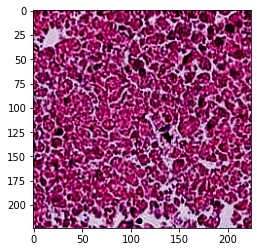

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

class SeparableConv(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.dwc = nn.Sequential(
            nn.Conv2d(input_channel, input_channel, kernel_size, stride, padding, dilation, groups=input_channel, bias=bias),
            nn.Conv2d(input_channel, output_channel, 1, 1, 0, 1, 1, bias=bias)
        )
    
    def forward(self, X):
        return self.dwc(X)

class Block(nn.Module):
    def __init__(self, input_channel, out_channel, reps, strides=1, relu=True, grow_first=True):
        super().__init__()
        if out_channel != input_channel or strides!=1:
            self.skipConnection = nn.Sequential(
                nn.Conv2d(input_channel, out_channel, 1, stride=strides, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.skipConnection = None
        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = input_channel
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))
            filters = out_channel
        
        for _ in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv(filters, filters, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv(input_channel, out_channel, 3, stride=1, padding=1, bias=False))
            rep.append(nn.BatchNorm2d(out_channel))

        if not relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3, strides, 1))

        self.rep = nn.Sequential(*rep)

    def forward(self, input):
        X = self.rep(input)

        if self.skipConnection:
            skip = self.skipConnection(input)
        else:
            skip = input
        
        X += skip
        return X

class Xception(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.relu = nn.ReLU(inplace=True)

        self.initBlock = nn.Sequential(
            nn.Conv2d(input_channel, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size = 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.block1=Block(64,128,2,2,relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block5=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block6=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block7=Block(728,728,3,1,relu=True,grow_first=True)

        #self.block8=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block9=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block10=Block(728,728,3,1,relu=True,grow_first=True)
        #self.block11=Block(728,728,3,1,relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,relu=True,grow_first=False)

        self.conv3 = SeparableConv(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, self.n_classes)

        #weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.initBlock(x)
        x = self.block1(x)
        
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        #x = self.block5(x)
        #x = self.block6(x)
        #x = self.block7(x)
        #x = self.block8(x)
        #x = self.block9(x)
        #x = self.block10(x)
        #x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Xception(input_channel=3, n_classes=2).to(device)
learning_rate = 0.0005
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("Xception2categoriesmodel.pth"):
        os.remove("Xception2categoriesmodel.pth")

      torch.save(model.state_dict(), 'Xception2categoriesmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

#!cp Xception2categoriesmodel.pth '/content/drive/My Drive/Histopathology data/'

print(acc)


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.3172

Test: Average loss: 0.1551, Accuracy: 8579/9096 (94.32%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2362

Test: Average loss: 0.0915, Accuracy: 8806/9096 (96.81%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1738

Test: Average loss: 0.0962, Accuracy: 8805/9096 (96.80%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1365

Test: Average loss: 0.0744, Accuracy: 8879/9096 (97.61%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1141

Test: Average loss: 0.0951, Accuracy: 8767/9096 (96.38%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1030

Test: Average loss: 0.1071, Accuracy: 8727/9096 (95.94%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0878

Test: Average loss: 0.0841, Accuracy: 8793/9096 (96.67%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0794

Test: Average loss: 0.0988, Accuracy: 8785/9096 (96.58%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0683

Test: Average loss: 0.0495, Accuracy: 8946/9096 (98.35%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0697

Test: Average loss: 0.0669, Accuracy: 8885/9096 (97.68%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0581

Test: Average loss: 0.0744, Accuracy: 8868/9096 (97.49%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0535

Test: Average loss: 0.1145, Accuracy: 8823/9096 (97.00%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0573

Test: Average loss: 0.0703, Accuracy: 8880/9096 (97.63%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0471

Test: Average loss: 0.0566, Accuracy: 8933/9096 (98.21%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0438

Test: Average loss: 0.0446, Accuracy: 8968/9096 (98.59%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0403

Test: Average loss: 0.1259, Accuracy: 8683/9096 (95.46%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0359

Test: Average loss: 0.1318, Accuracy: 8714/9096 (95.80%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0393

Test: Average loss: 0.0778, Accuracy: 8869/9096 (97.50%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0329

Test: Average loss: 0.0343, Accuracy: 8994/9096 (98.88%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0284

Test: Average loss: 0.0289, Accuracy: 9010/9096 (99.05%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0294

Test: Average loss: 0.0369, Accuracy: 8986/9096 (98.79%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0250

Test: Average loss: 0.0315, Accuracy: 9002/9096 (98.97%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0229

Test: Average loss: 0.0389, Accuracy: 8966/9096 (98.57%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0233

Test: Average loss: 0.0404, Accuracy: 8986/9096 (98.79%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0283, Accuracy: 9008/9096 (99.03%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0186

Test: Average loss: 0.0267, Accuracy: 9019/9096 (99.15%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0185

Test: Average loss: 0.0605, Accuracy: 8921/9096 (98.08%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0246

Test: Average loss: 1.3104, Accuracy: 7677/9096 (84.40%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0234

Test: Average loss: 17.0882, Accuracy: 5067/9096 (55.71%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0458

Test: Average loss: 0.0319, Accuracy: 9006/9096 (99.01%)

99.15347405452947


In [ ]:
!cp Xception2categoriesmodel.pth '/content/drive/My Drive/SGD/'

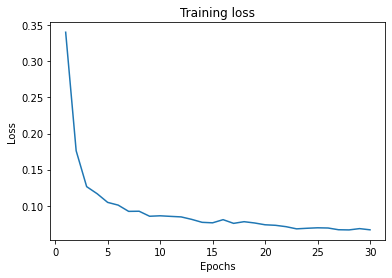

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

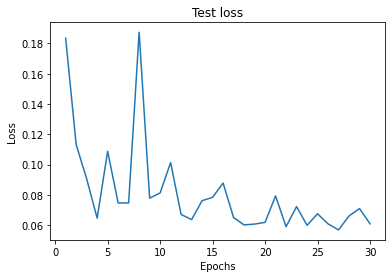

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

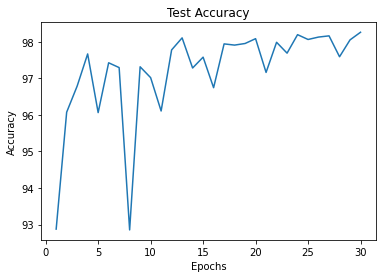

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()